### 해당 파일을 아래와 같은 구성으로 넣어주세요
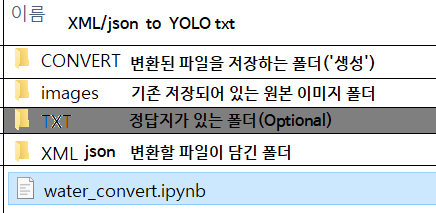

- 이 코드를 실행하면 XML 및 json 파일을 YOLO based txt 파일로 변환할 수 있음
- (추가 수정_241114: XML 파일 전용으로 코드 수정, JSON 파일 전용은 별도 파일 참고)
- 이때 변환된 CONVERT 폴더 속 txt 파일의 class를 아래 세 타입으로 분류함
- 1. class0 은 0(pothole)만 있는 단일 라벨링
- 2. class1 은 0을 포함하지만 1 이상의 class를 하나 이상 포함한 복수 라벨링
- 3. classNAN 은 0을 포함하지 않고 있는 라벨링 (class1,2의 개수는 무관)

# What to do?
- classNAN으로 분류된 파일은 test set 으로 이동시키거나 드롭
- class1으로 분류된 파일은 0만 남기고 1 이상의 값을 삭제 후 저장
- class0으로 분류된 파일은 그대로 train set으로서 사용

In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET

# 폴더 경로 설정
xml_dir = "./XML"
images_dir = "./images"
txt_dir = "./TXT"
unmatched_dir = "./UNMATCHED"
convert_dir = "./CONVERT"
images_class_dir = "./images_class"

# 필요한 폴더 생성
os.makedirs(txt_dir, exist_ok=True)
os.makedirs(images_class_dir, exist_ok=True)

# XML 파일을 YOLO 형식으로 변환하는 함수
def xml_to_yolo(xml_path, output_txt_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_width = int(root.find('size/width').text)
    image_height = int(root.find('size/height').text)

    yolo_annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = 0 if class_name == "pothole" else 1

        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        x_center = ((xmin + xmax) / 2) / image_width
        y_center = ((ymin + ymax) / 2) / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    with open(output_txt_path, "w") as file:
        for line in yolo_annotations:
            file.write(line + "\n")

# 파일 매칭 확인 및 변환 처리
xml_files = sorted([f for f in os.listdir(xml_dir) if f.endswith(".xml")])
image_files = sorted([f for f in os.listdir(images_dir) if os.path.splitext(f)[1].lower() in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']])

xml_names = {os.path.splitext(f)[0] for f in xml_files}
image_names = {os.path.splitext(f)[0] for f in image_files}

# 매칭된 파일과 매칭되지 않은 파일 확인
matched_files = xml_names.intersection(image_names)
unmatched_files = xml_names.symmetric_difference(image_names)

# 매칭되지 않은 파일이 있을 경우에만 UNMATCHED 및 CONVERT 폴더 생성
if unmatched_files:
    os.makedirs(unmatched_dir, exist_ok=True)
    os.makedirs(convert_dir, exist_ok=True)
    unmatched_log_path = os.path.join(convert_dir, "differences.txt")

    # 매칭되지 않은 파일을 UNMATCHED 폴더로 이동 및 기록
    with open(unmatched_log_path, 'w') as f:
        for unmatched in unmatched_files:
            moved = False  # 파일 이동 여부 체크
            
            # 매칭되지 않은 XML 파일이 있으면 이동
            xml_path = os.path.join(xml_dir, unmatched + ".xml")
            if os.path.exists(xml_path):
                shutil.move(xml_path, unmatched_dir)
                f.write(unmatched + ".xml\n")
                moved = True

            # 매칭되지 않은 이미지 파일 확장자별로 존재 확인 후 이동
            for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
                image_path = os.path.join(images_dir, unmatched + ext)
                if os.path.exists(image_path):
                    shutil.move(image_path, unmatched_dir)
                    f.write(unmatched + ext + "\n")
                    moved = True

            # 매칭되지 않은 파일이 없을 경우 경고 메시지
            if not moved:
                print(f"경고: {unmatched} 파일을 찾을 수 없습니다.")

# 매칭된 파일 변환
for matched in matched_files:
    xml_path = os.path.join(xml_dir, matched + ".xml")
    txt_filename = matched + ".txt"
    output_txt_path = os.path.join(txt_dir, txt_filename)

    # XML 파일을 YOLO 형식으로 변환하여 TXT 폴더에 저장
    xml_to_yolo(xml_path, output_txt_path)

    # 매칭된 이미지 파일을 images_class 폴더로 복사
    for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif']:
        image_path = os.path.join(images_dir, matched + ext)
        if os.path.exists(image_path):
            shutil.copy(image_path, images_class_dir)
            break  # 이미지를 찾고 복사했으면 종료

# 파일 개수 및 처리 결과 출력
print(f"총 XML 파일 개수: {len(xml_files)}")
print(f"총 이미지 파일 개수: {len(image_files)}")
print(f"매칭된 파일 개수: {len(matched_files)}")
print(f"매칭되지 않은 파일 개수: {len(unmatched_files)}")

if unmatched_files:
    print(f"매칭되지 않은 파일 목록은 {unmatched_log_path}에 저장되었습니다.")
else:
    print("모든 파일이 정상적으로 매칭되었습니다.")


총 XML 파일 개수: 4805
총 이미지 파일 개수: 4805
매칭된 파일 개수: 4805
매칭되지 않은 파일 개수: 0
매칭되지 않은 파일 목록은 ./CONVERT\differences.txt에 저장되었습니다.
